# Examen práctico 
## Parcial 2 Laboratorio de Aprendizaje Estadístico
Diego Lozoya Morales | 745345

# Paqueterías

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree


import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [2]:
def calibracion(probabilidades, y_test):
    df_calibracion = pd.DataFrame({
        'probabilidades':probabilidades,
        'y':y_test
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['probabilidades'], q=15, labels=False, duplicates='drop')+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure()
    plt.plot(grouped.probabilidades, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.probabilidades, grouped.probabilidades, label="Real", marker="o", color=colors[1])
    plt.xlabel("Probabilidad")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.legend()
    plt.show()

def histograma(probabilidades, y_test):
     df = pd.DataFrame({
     'real': y_test,
     'probabilidades': probabilidades
     })

     plt.figure()
     plt.hist(df[df.real == 1]['probabilidades'], density=True, color=colors[0], alpha=0.5, label = '1')
     plt.hist(df[df.real == 0]['probabilidades'], density=True, color=colors[1], alpha=0.5, label = '0')
     plt.title(f'Histograma de probabilidades')
     plt.xlabel("Probabilidad")
     plt.ylabel(" ")
     plt.legend()
     plt.show()

def roc(probabilidades, y_test):
     fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
     plt.figure()
     plt.plot(fpr, fnp, color=colors[0], lw=2)
     plt.plot([0, 1], [0, 1], color=colors[1], linestyle='--', lw=2, label='Clasificador aleatorio')
     plt.xlabel('1 - Specificity')
     plt.ylabel('Sensitivity')
     plt.title('ROC curve')
     plt.legend()
     plt.show()

def loss(train_loss, test_loss):
    plt.figure()
    plt.plot(train_loss, label='train', color=colors[0])
    plt.plot(test_loss, label='test', color=colors[1])
    plt.title('Loss')
    plt.xlabel('Iteración')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

def importance(features, importances, n_var, importance_type):
    model_importance = pd.DataFrame({
          'Variable': features,
          'Importancia': importances
    })
    model_importance = model_importance.sort_values(by='Importancia', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list("custom_coolwarm", [colors[1], colors[0]])
    custom_palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, len(model_importance))])

    plt.figure()
    sns.barplot(x="Importancia", y="Variable", data=model_importance, palette=custom_palette)
    for index, value in enumerate(model_importance["Importancia"]):
          plt.text(value - 0.001, index, f"{value:.3f}", va="center", ha='right')
    plt.xlabel('Importancia')
    plt.xlim(0, max(model_importance["Importancia"]) + 0.03)
    plt.ylabel('Variables')
    plt.title(f'{n_var} variables más importantes tipo {importance_type}')
    plt.show()

def depth2Tree(X_train, y_train):
     tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

     plt.figure()
     plot_tree(tree, feature_names=X_train.keys(), filled=True, rounded=True, proportion=True, class_names=True)
     plt.show()

def decision_tree(X_train, X_test, y_train, y_test):
     pipeline = Pipeline([
          ('tree', DecisionTreeClassifier(random_state=42))
     ])

     params = {
          'tree__max_depth': list(range(1, 10)),
          'tree__max_features': ['log2', 'sqrt', 10, 11, 12],
          'tree__min_samples_split': list(range(2, 10)),
          'tree__min_samples_leaf': list(range(5, 15))
     }
     tree_grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, scoring="roc_auc")
     tree_grid.fit(X_train, y_train)

     best_model = tree_grid.best_estimator_.named_steps['tree']
     probabilidades = best_model.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)

     return print(f'Mejor modelo: {tree_grid.best_params_}\n\nAUC: {auc:.4f}\nGini: {gini:.4f}')

def random_forest(X_train, X_test, y_train, y_test):
     pipeline = Pipeline([
          ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
     ])

     params = {
          'rf__n_estimators': [400, 450, 500, 550, 600],
          'rf__max_depth': list(range(10, 15)),
          'rf__max_features': ['log2', 'sqrt', 10, 12],
     }
     rf_grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, scoring="roc_auc")
     rf_grid.fit(X_train, y_train)

     best_model = rf_grid.best_estimator_.named_steps['rf']
     probabilidades = best_model.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)

     features = X_train.columns
     importances = best_model.feature_importances_

     importance(features, importances, 5, 'Feature Importance')

     return print(f'Mejor modelo: {rf_grid.best_params_}\n\nAUC: {auc:.4f}\nGini: {gini:.4f}')

# Data

In [3]:
data = pd.read_csv('Data/hr_role.csv')
data['Attrition'] = data['Attrition'].map({'Yes': True, 'No': False})
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,True,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,False,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,True,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,False,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,False,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


## Variable dependiente

In [4]:
target = 'Attrition'
y = data[target]

# Feature engineering

## Dummies

In [5]:
data = pd.get_dummies(data)
data.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,True,1102,1,2,2,94,3,2,5993,...,False,False,True,False,False,False,True,True,False,True
1,49,False,279,8,1,3,61,2,2,5130,...,False,True,False,False,False,True,False,True,True,False
2,37,True,1373,2,2,4,92,2,1,2090,...,False,False,False,False,False,False,True,True,False,True
3,33,False,1392,3,4,4,56,3,1,2909,...,False,True,False,False,False,True,False,True,False,True
4,27,False,591,2,1,1,40,3,1,3468,...,False,False,False,False,False,True,False,True,True,False


## Transformaciones

## Nuevas variables

# Preparación de datos

## Cross validation

In [6]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Árbol (depth 2)

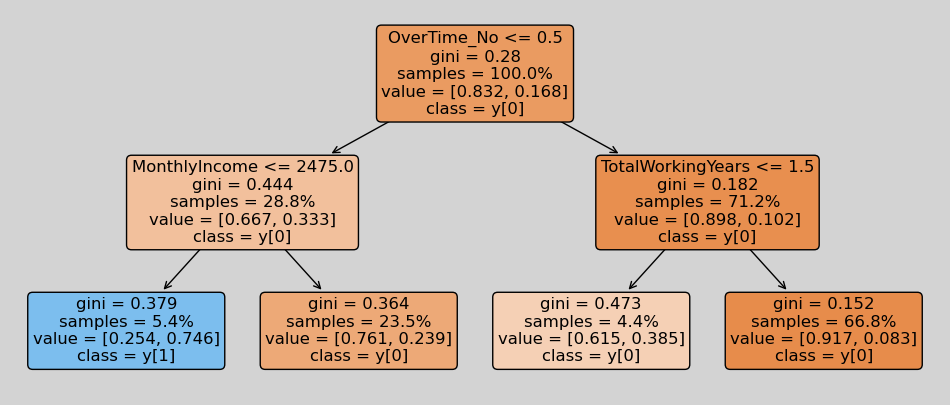

In [7]:
depth2Tree(X_train, y_train)

**INTERPRETACION**

# Mejor árbol de decisión

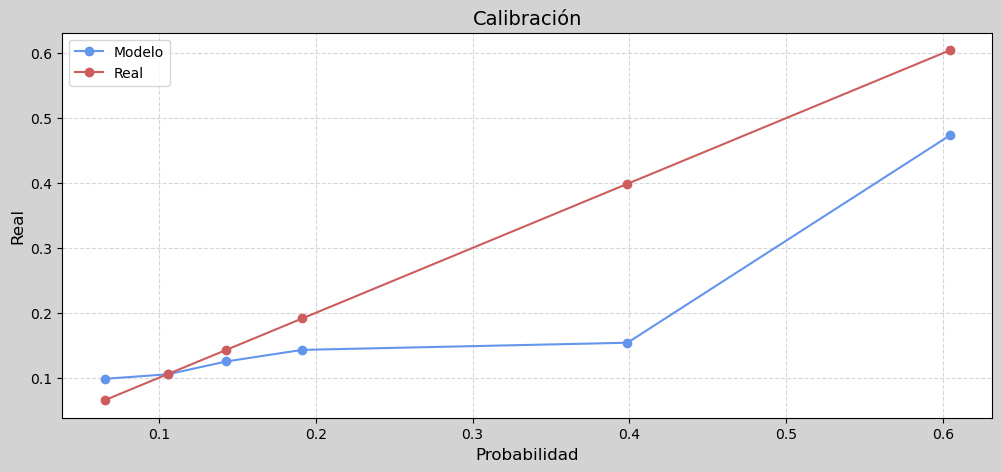

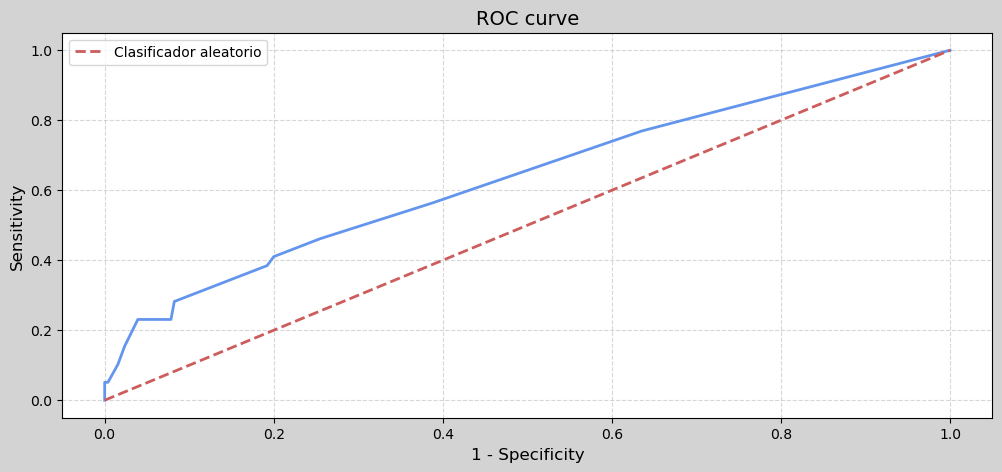

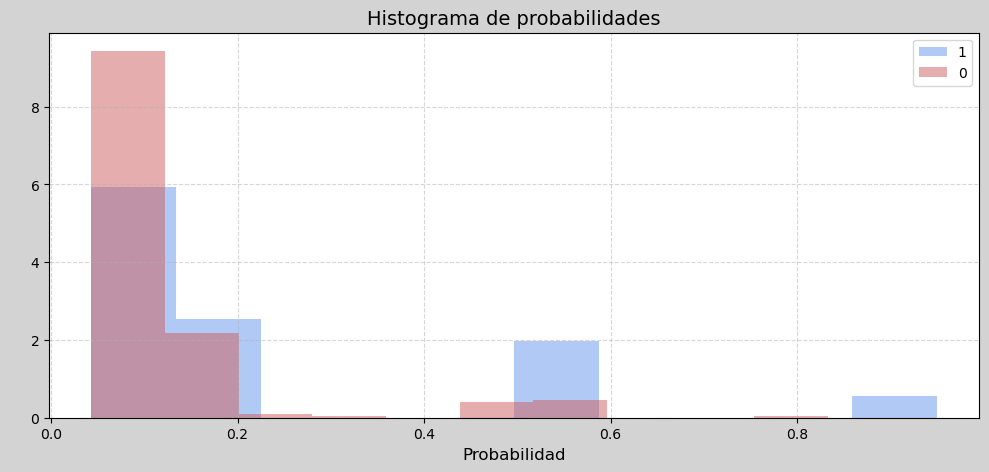

Mejor modelo: {'tree__max_depth': 4, 'tree__max_features': 12, 'tree__min_samples_leaf': 8, 'tree__min_samples_split': 2}

AUC: 0.6345
Gini: 0.2691


In [8]:
decision_tree(X_train, X_test, y_train, y_test)

# Random Forest

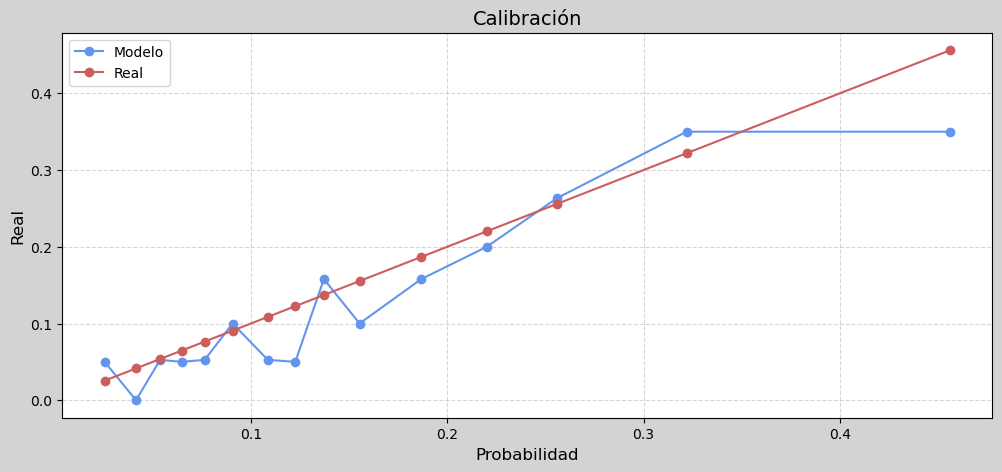

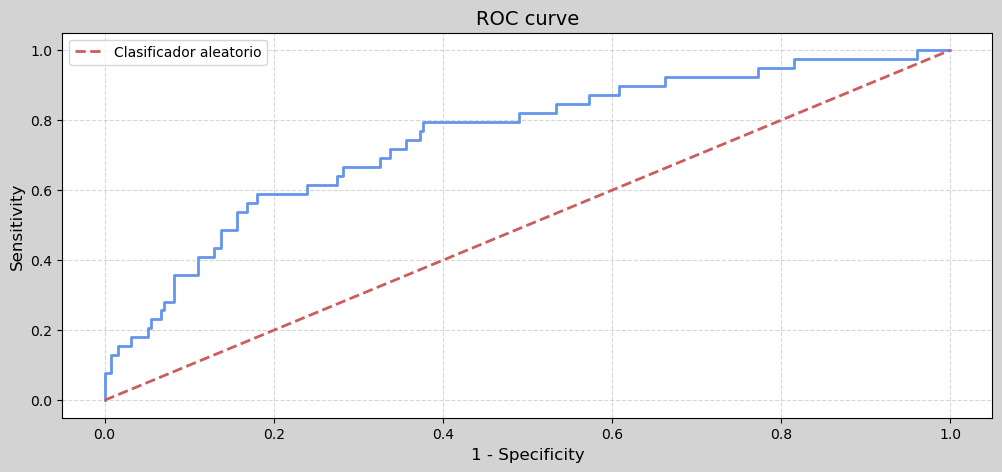

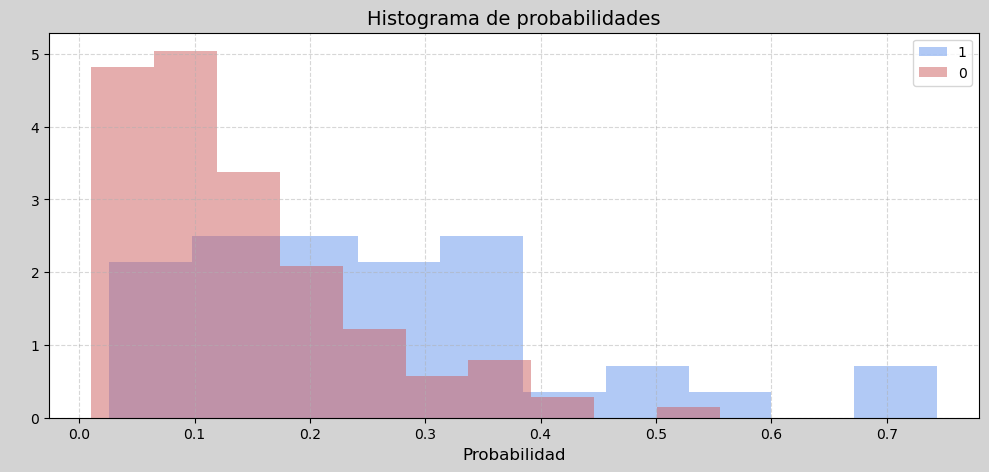

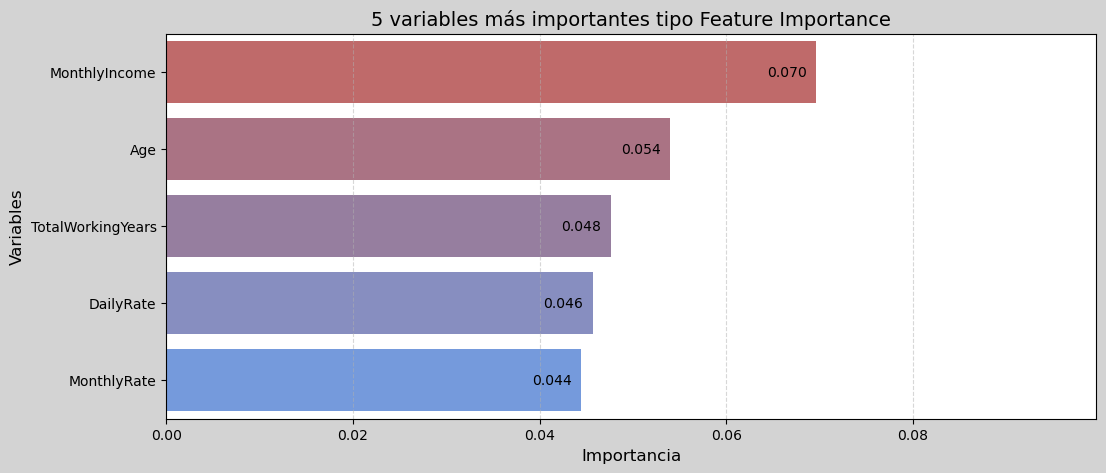

Mejor modelo: {'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__n_estimators': 500}

AUC: 0.7482
Gini: 0.4964


In [9]:
random_forest(X_train, X_test, y_train, y_test)

# XGBoost

# Lightgbm

# CatBoost

# Conlusiones generales